# Training 

## importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
import emlearn


2026-01-01 18:58:32.384863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the Data Set

In [2]:
Enging_df = pd.read_csv("data/Engine Journal Bearings Dataset/Engine_Bearings_Dataset.csv")
Enging_df.head()

,Unnamed: 0,Time,Demand 1,Control 1,Output Drive 1,Channel 1,Channel 2,Channel 3,Channel 4,Channel 1 Kurtosis,...,Rear Input 3,Rear Input 4,Rear Input 5,Rear Input 6,Rear Input 7,Rear Input 8,RPM,Humidity,Temperature,Engine_status
0,0,0.001400,0.125011,0.193516,0.0,0.143790,0.252379,0.200436,1.449570e-15,2.22364,...,0,0,0,0,0,0,1000,0,-10,0
1,1,0.001400,0.125011,0.193516,0.0,0.143790,0.252379,0.200436,1.449570e-15,2.22364,...,0,0,0,0,0,0,1000,0,-10,0
2,2,0.001467,0.125011,0.193516,0.0,0.143790,0.252379,0.200436,1.449570e-15,2.22364,...,0,0,0,0,0,0,1000,0,-10,0
3,3,0.006533,0.125011,0.193516,0.0,0.128777,0.214454,0.165380,1.993490e-15,2.82642,...,0,0,0,0,0,0,1000,0,-10,0
4,4,0.009800,0.125011,0.194175,0.0,0.185147,0.258471,0.197577,1.656360e-15,2.47260,...,0,0,0,0,0,0,1000,0,-10,0


## Extracting required features

In [3]:
required_features = ['Channel 3','Channel 3 Kurtosis', 'Temperature' ,'Humidity' ,'Engine_status']
Feature_df = Enging_df[required_features]

In [4]:
Feature_df.head()

,Channel 3,Channel 3 Kurtosis,Temperature,Humidity,Engine_status
0,0.200436,2.78879,-10,0,0
1,0.200436,2.78879,-10,0,0
2,0.200436,2.78879,-10,0,0
3,0.165380,2.43508,-10,0,0
4,0.197577,2.23967,-10,0,0


In [5]:
Feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390263 entries, 0 to 390262
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Channel 3           390263 non-null  float64
 1   Channel 3 Kurtosis  390263 non-null  float64
 2   Temperature         390263 non-null  int64  
 3   Humidity            390263 non-null  int64  
 4   Engine_status       390263 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 14.9 MB


In [6]:
Feature_df.describe()

,Channel 3,Channel 3 Kurtosis,Temperature,Humidity,Engine_status
count,390263.000000,390263.000000,390263.000000,390263.000000,390263.000000
mean,1.685951,4.413186,15.397386,49.783223,0.537233
std,1.573012,7.295369,19.698300,41.991290,0.498612
min,0.097681,1.006260,-10.000000,0.000000,0.000000
25%,1.202145,2.952250,0.000000,0.000000,0.000000
50%,1.294640,3.032590,15.000000,50.000000,1.000000
75%,1.526540,3.213305,30.000000,100.000000,1.000000
max,15.755000,169.596000,45.000000,100.000000,1.000000


In [7]:
Feature_df.isna().sum()

Channel 3             0
Channel 3 Kurtosis    0
Temperature           0
Humidity              0
Engine_status         0
dtype: int64

In [8]:
Feature_df.dtypes

Channel 3             float64
Channel 3 Kurtosis    float64
Temperature             int64
Humidity                int64
Engine_status           int64
dtype: object

## Visualize the relation between the featurs 

<Figure size 1400x600 with 0 Axes>

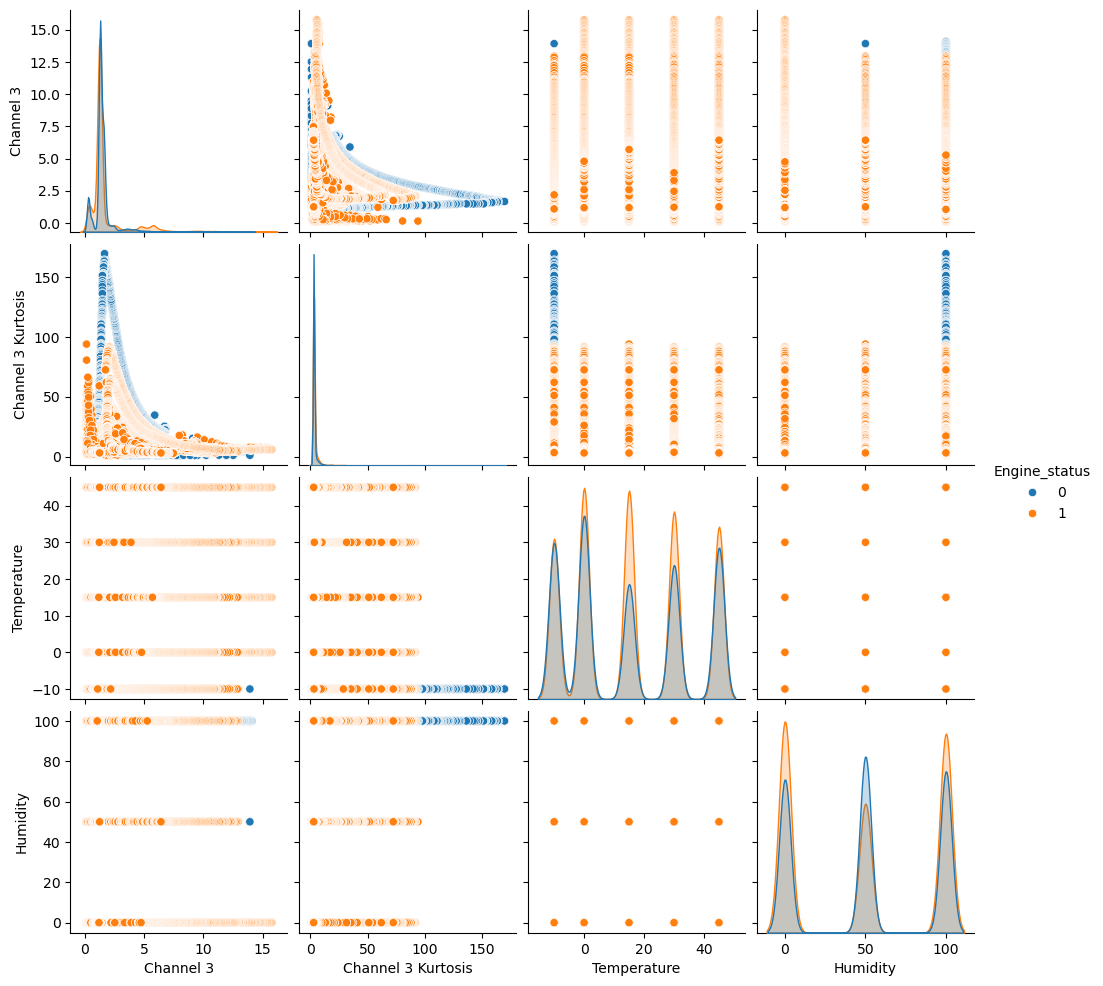

In [9]:
plt.figure(figsize=(14, 6))
sns.pairplot(Feature_df, hue="Engine_status", diag_kind="kde")
plt.show()

## NN Model

In [9]:
def nnModel(X_train,X_test ,y_train  , y_test):
    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

    # Evaluate
    y_pred = model.predict(X_test).argmax(axis=1)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, y_pred))

    return model

In [10]:

def postTrainNNQuantizeQndDeploy(model, X_train, X_test, y_train, y_test, model_name='engine_nn_quant'):
    """
    Post-training int8 quantization for ESP32 TFLite Micro deployment.
    No tfmot needed - uses built-in TF Lite converter.
    
    Parameters:
    - model: Trained Keras model
    - X_train/X_test: Data for calibration/evaluation
    - y_train/y_test: Labels
    - model_name: File prefix
    
    Returns:
    - tflite_bytes: Quantized model
    """
    # Representative dataset (calibration – use subset of train)
    def representative_data_gen():
        for i in range(100):  # 100-500 samples typical
            yield [X_train[i:i+1].astype(np.float32)]
    
    # Converter with full int8 quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    print("Converting to int8 TFLite (post-training)...")
    tflite_model = converter.convert()
    
    # Save TFLite
    tflite_path = f'{model_name}.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"TFLite saved: {tflite_path} ({len(tflite_model)/1024:.1f} KB)")
    
    # Generate C header for ESP32
    header_path = f'{model_name}.h'
    os.system(f'xxd -i {tflite_path} > {header_path}')
    print(f"C header generated: {header_path}")
    print("Ready for ESP32 TensorFlow Lite Micro.")
    
    # Evaluation (on float model – quantized similar)
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = y_pred_prob.argmax(axis=1)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Float Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Float Model Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, y_pred))
    
    return tflite_model

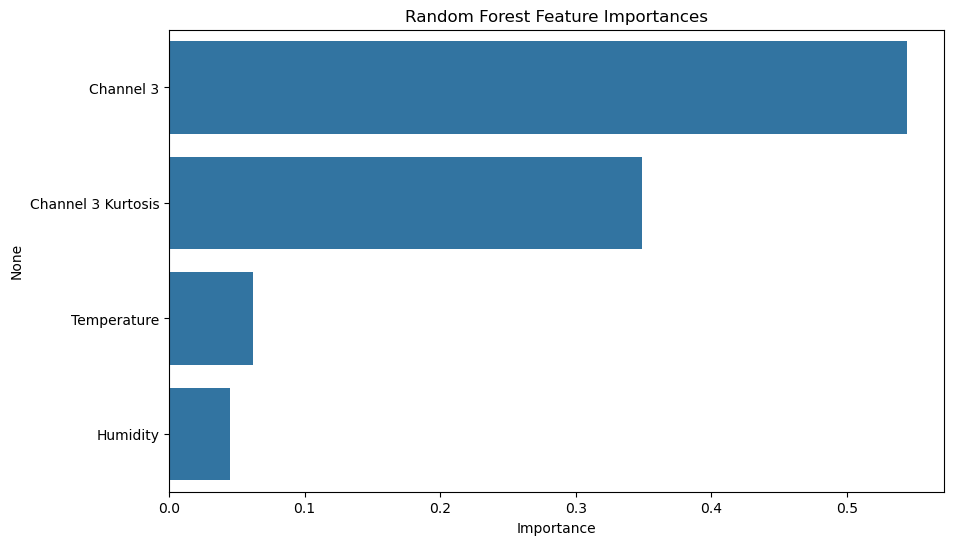

## Training without PCA

In [11]:
X = Feature_df.drop(['Engine_status', 'Humidity'], axis=1)
y = Feature_df['Engine_status']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE for balance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [ ]:

print("Feature Means (scaler.mean_):")
print(scaler.mean_)

print("\nFeature Standard Deviations (scaler.scale_):")
print(scaler.scale_)

print("\nFeature Variances (scaler.var_):")
print(scaler.var_)

Feature Means (scaler.mean_):
[ 1.68595058  4.4131862  15.39738587]

Feature Standard Deviations (scaler.scale_):
[ 1.5730099   7.29535932 19.69827512]

Feature Variances (scaler.var_):
[  2.47436015  53.22226767 388.0220426 ]


/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.6536 - loss: 0.5990 - val_accuracy: 0.6725 - val_loss: 0.5585
Epoch 2/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6683 - loss: 0.5705 - val_accuracy: 0.6760 - val_loss: 0.5524
Epoch 3/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6720 - loss: 0.5629 - val_accuracy: 0.6822 - val_loss: 0.5455
Epoch 4/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.6762 - loss: 0.5574 - val_accuracy: 0.6854 - val_loss: 0.5407
Epoch 5/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6786 - loss: 0.5538 - val_accuracy: 0.6858 - val_loss: 0.5451
Epoch 6/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6784 - loss: 0.5523 - val_accuracy: 0.6815 - val_loss: 0.5454
Epoch 7/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6794 - loss: 0.5508 - val_accuracy: 0.6884 - val_loss: 0.5365
Epoch 8/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6804 - loss: 0

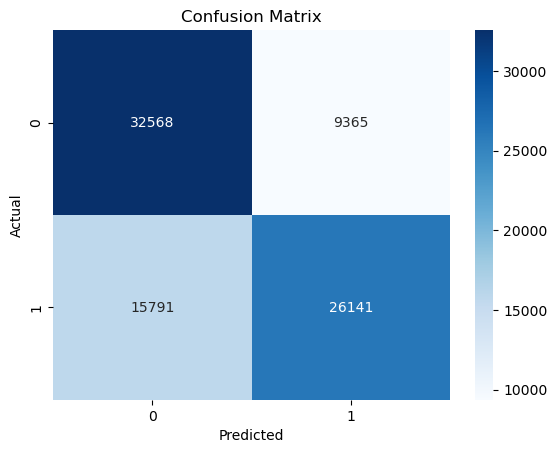

Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     41933
           1       0.74      0.62      0.68     41932

    accuracy                           0.70     83865
   macro avg       0.70      0.70      0.70     83865
weighted avg       0.70      0.70      0.70     83865



In [13]:
nn_model = nnModel(X_train,X_test ,y_train  , y_test)

### Quantize

Converting to int8 TFLite (post-training)...
INFO:tensorflow:Assets written to: /tmp/tmpcwby4n9n/assets


INFO:tensorflow:Assets written to: /tmp/tmpcwby4n9n/assets


Saved artifact at '/tmp/tmpcwby4n9n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140602973826576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973826960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973828496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973828112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973828880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973826768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973827920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973828688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973829456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973827152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140602973828304: TensorS

/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1767196790.506826   50114 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767196790.506855   50114 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-31 17:59:50.507217: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcwby4n9n
2025-12-31 17:59:50.508031: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-31 17:59:50.508039: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpcwby4n9n
I0000 00:00:1767196790.515335   50114 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-12-31 17:59:50.517117: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
20

TFLite saved: engine_nn_quant.tflite (15.9 KB)
C header generated: engine_nn_quant.h
Ready for ESP32 TensorFlow Lite Micro.


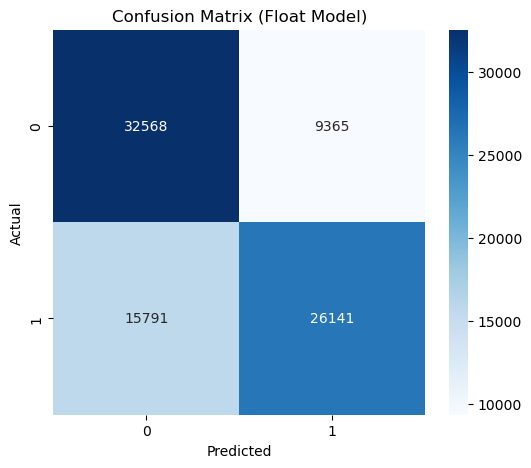

Float Model Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     41933
           1       0.74      0.62      0.68     41932

    accuracy                           0.70     83865
   macro avg       0.70      0.70      0.70     83865
weighted avg       0.70      0.70      0.70     83865



In [14]:
tflite_model = postTrainNNQuantizeQndDeploy(nn_model, X_train, X_test, y_train, y_test,model_name='engine_nn_quant')

---

## Scaling, PCA, SMOTE balanceing and splitting

In [15]:

# PCA for separation (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f'Reduced to {X_pca.shape[1]} components')

# SMOTE for balance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_pca, y)

# # Re-visualize
# df_res = pd.DataFrame(X_res, columns=[f'PC{i+1}' for i in range(X_res.shape[1])])
# df_res['Engine_status'] = y_res
# sns.pairplot(df_res, hue='Engine_status')
# plt.show()

# Split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

Reduced to 3 components


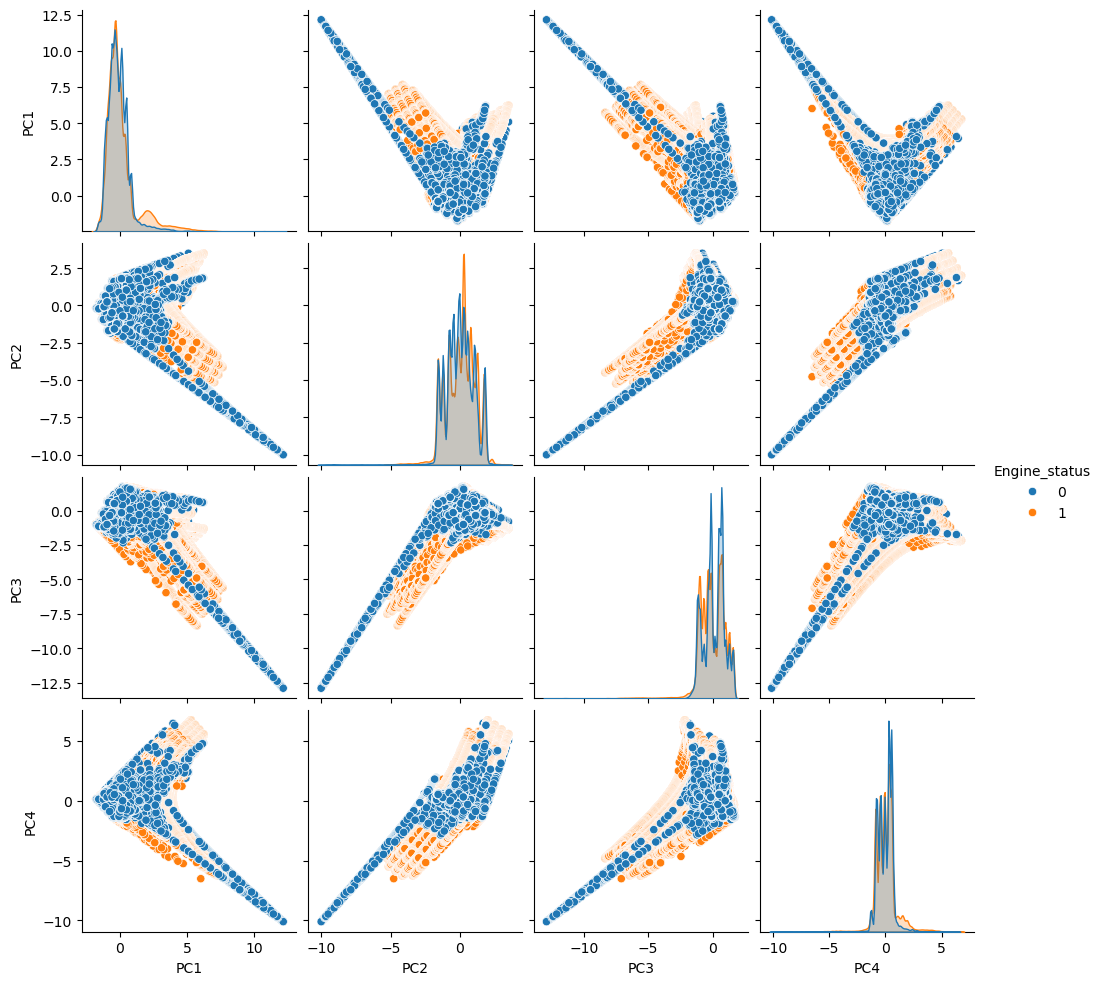

Epoch 1/50


/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8387/8387 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6523 - loss: 0.5987 - val_accuracy: 0.6643 - val_loss: 0.5678
Epoch 2/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6683 - loss: 0.5723 - val_accuracy: 0.6813 - val_loss: 0.5523
Epoch 3/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6716 - loss: 0.5663 - val_accuracy: 0.6822 - val_loss: 0.5513
Epoch 4/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6720 - loss: 0.5618 - val_accuracy: 0.6829 - val_loss: 0.5445
Epoch 5/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6746 - loss: 0.5583 - val_accuracy: 0.6758 - val_loss: 0.5541
Epoch 6/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6759 - loss: 0.5553 - val_accuracy: 0.6774 - val_loss: 0.5465
Epoch 7/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6768 - loss: 0.5541 - val_accuracy: 0.6806 - val_loss: 0.5369
Epoch 8/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6776 - loss: 0.5525 - val

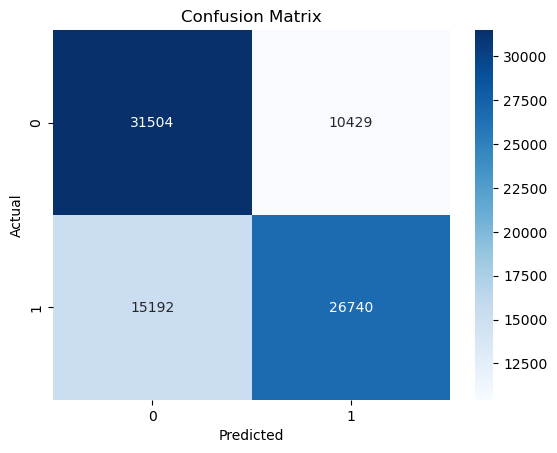

Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.67      0.75      0.71     41933
           1       0.72      0.64      0.68     41932

    accuracy                           0.69     83865
   macro avg       0.70      0.69      0.69     83865
weighted avg       0.70      0.69      0.69     83865



In [17]:
nn_pca_model = nnModel(X_train_pca, X_test_pca ,y_train_pca  , y_test_pca)

Converting to int8 TFLite (post-training)...
INFO:tensorflow:Assets written to: /tmp/tmpv7p8_5rf/assets


INFO:tensorflow:Assets written to: /tmp/tmpv7p8_5rf/assets


Saved artifact at '/tmp/tmpv7p8_5rf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140600998797456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998798608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998798992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998799952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998799760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998799184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998799568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998798800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998800720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998800144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600998801104: Tens

/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1767199078.783160   50114 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767199078.783181   50114 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-31 18:37:58.783544: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv7p8_5rf
2025-12-31 18:37:58.784856: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-31 18:37:58.784865: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpv7p8_5rf
2025-12-31 18:37:58.796406: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-31 18:37:58.844752: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle 

TFLite saved: engine_nn_pca_quant.tflite (16.0 KB)
C header generated: engine_nn_pca_quant.h
Ready for ESP32 TensorFlow Lite Micro.


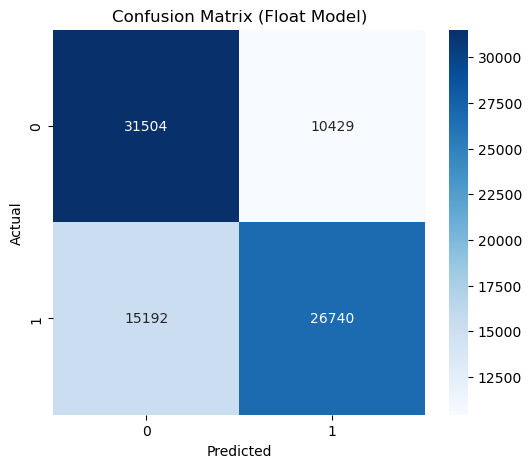

Float Model Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.67      0.75      0.71     41933
           1       0.72      0.64      0.68     41932

    accuracy                           0.69     83865
   macro avg       0.70      0.69      0.69     83865
weighted avg       0.70      0.69      0.69     83865



In [18]:
tflite_pcs_model = postTrainNNQuantizeQndDeploy(nn_pca_model, X_train_pca, X_test_pca ,y_train_pca  , y_test_pca ,model_name='engine_nn_pca_quant')

---

## 1D conv

In [19]:

def CNN_1D(X_train, X_test, y_train, y_test, epochs=50):
    # Reshape for 1D CNN (features as "timesteps")
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    cnn_model = Sequential([
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train with early stopping for robustness
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    cnn_model.fit(X_train_cnn, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stop], verbose=1)
    
    # Predict with thresholding
    y_pred_prob = cnn_model.predict(X_test_cnn)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Evaluation
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fault']))
    
    return cnn_model
    


In [20]:
def postTrainCNNQuantize(model, X_train, model_name='cnn_quant'):
    X_train_sample = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    def representative_data_gen():
        for i in range(100):
            yield [X_train_sample[i:i+1].astype(np.float32)]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    tflite_model = converter.convert()
    
    with open(f'{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
    
    os.system(f'xxd -i {model_name}.tflite > {model_name}.h')
    print(f"Post-training quantized model ready: {model_name}.tflite / {model_name}.h")
    
    return tflite_model

Epoch 1/50


/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8387/8387 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6426 - loss: 0.6081 - val_accuracy: 0.6689 - val_loss: 0.5738
Epoch 2/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6633 - loss: 0.5777 - val_accuracy: 0.6686 - val_loss: 0.5636
Epoch 3/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6679 - loss: 0.5706 - val_accuracy: 0.6702 - val_loss: 0.5569
Epoch 4/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6705 - loss: 0.5652 - val_accuracy: 0.6740 - val_loss: 0.5526
Epoch 5/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6745 - loss: 0.5613 - val_accuracy: 0.6771 - val_loss: 0.5532
Epoch 6/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6755 - loss: 0.5575 - val_accuracy: 0.6778 - val_loss: 0.5532
Epoch 7/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6770 - loss: 0.5557 - val_accuracy: 0.6832 - val_loss: 0.5503
Epoch 8/50
8387/8387 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6770 - loss: 0.5536 - val

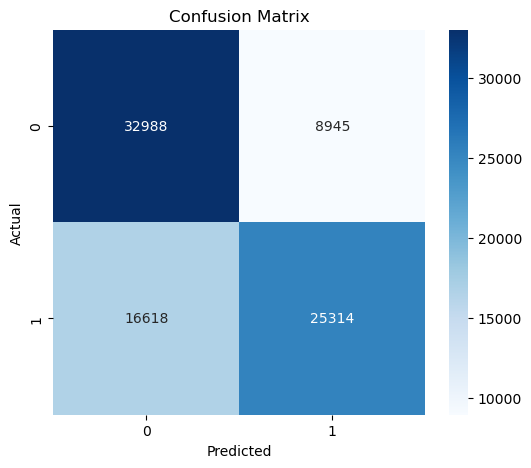

Accuracy: 0.70
              precision    recall  f1-score   support

      Normal       0.67      0.79      0.72     41933
       Fault       0.74      0.60      0.66     41932

    accuracy                           0.70     83865
   macro avg       0.70      0.70      0.69     83865
weighted avg       0.70      0.70      0.69     83865



In [21]:
cnn_model = CNN_1D(X_train_pca, X_test_pca ,y_train_pca  , y_test_pca)

In [22]:
tflite_cnn_model = postTrainCNNQuantize(cnn_model, X_train_pca, model_name='cnn_quant')

INFO:tensorflow:Assets written to: /tmp/tmpyyp0kj20/assets


INFO:tensorflow:Assets written to: /tmp/tmpyyp0kj20/assets


Saved artifact at '/tmp/tmpyyp0kj20'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140600997618768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997621264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997612816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997621072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997619152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997622800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997623568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600997624528: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Post-training quantized model ready: cnn_quant.tflite / cnn_quant.h


W0000 00:00:1767200217.049898   50114 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767200217.049916   50114 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-31 18:56:57.050095: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyyp0kj20
2025-12-31 18:56:57.050818: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-31 18:56:57.050827: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpyyp0kj20
2025-12-31 18:56:57.057333: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-31 18:56:57.093225: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpyyp0kj20
2025-12-31 18:56:57.111439: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 61344 microseconds.
fully_quantize: 0, inference_type: 6, input_i

---


### Randome Forest Quantization Func

In [23]:

def randomForest(X_train, X_test, y_train, y_test, num_estimators=2):
    # Instantiate and train
    rf_model = RandomForestClassifier(
        n_estimators=num_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predict (direct classes)
    y_pred = rf_model.predict(X_test)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fault'],  # Binary names; adjust for multi-class
                yticklabels=['Normal', 'Fault'])
    plt.title('Confusion Matrix - Random Forest')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print("Random Forest Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fault']))
    
    # Feature Importances with generic names (since array post-PCA)
    importances = rf_model.feature_importances_
    feat_names = X.columns
    feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
    print("Top 5 Feature Importances:\n", feat_imp.head(5))
    
    # Optional bar plot
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Random Forest Feature Importances')
    plt.xlabel('Importance')
    plt.show()
    
    return rf_model

In [24]:
def postTrainRandForsQuantize(rf_model, model_export_name):
    # emlearn C code
    c_model = emlearn.convert(rf_model, method='inline')
    c_model.save(name=model_export_name, file=f'{model_export_name}.h')
    print(f"Random Forest C header '{model_export_name}.h' generated for ESP32.")

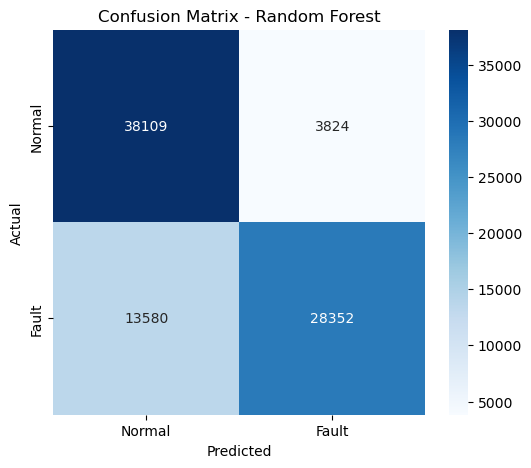

Accuracy: 0.79
Random Forest Classification Report:

              precision    recall  f1-score   support

      Normal       0.74      0.91      0.81     41933
       Fault       0.88      0.68      0.77     41932

    accuracy                           0.79     83865
   macro avg       0.81      0.79      0.79     83865
weighted avg       0.81      0.79      0.79     83865

Top 5 Feature Importances:
 Channel 3             0.567413
Channel 3 Kurtosis    0.413606
Temperature           0.018981
dtype: float64


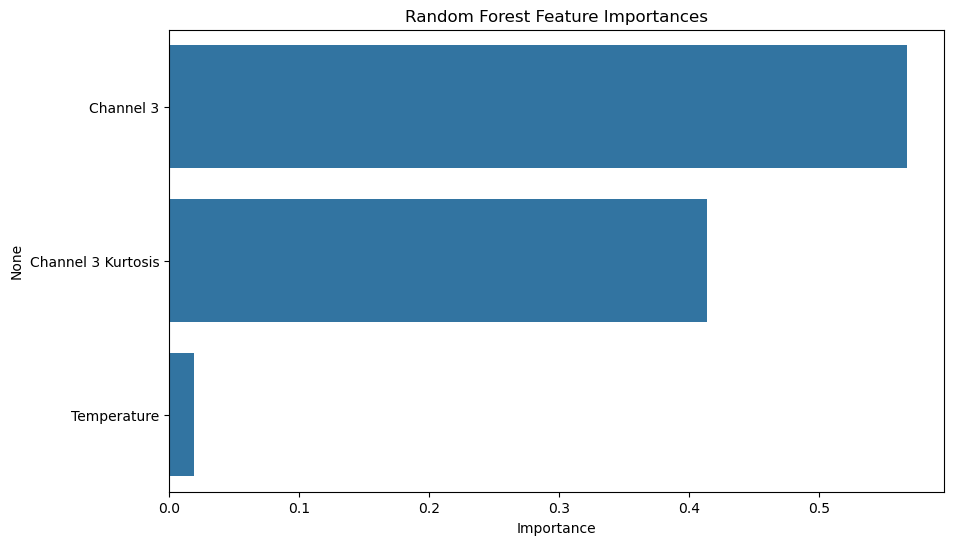

In [25]:
rf_model = randomForest(X_train, X_test, y_train, y_test)

In [26]:
postTrainRandForsQuantize(rf_model, 'rf_fault_engine_')

Random Forest C header 'rf_fault_engine_.h' generated for ESP32.


---


## RNN

In [27]:
def createSequences(X, y, timesteps=20):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y.iloc[i + timesteps]) 
    return np.array(X_seq), np.array(y_seq)

In [ ]:

def tinyGru_RNN(X_train_seq, X_test_seq, y_train_seq, y_test_seq, timesteps=20, features=3, epochs=50, batch_size=32):
    # Tiny GRU RNN for binary classification
    model = Sequential([
        tf.keras.layers.GRU(32, return_sequences=True,activation='sigmoid',  input_shape=(timesteps, features)),  # Small units for ESP32
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.GRU(16, activation='sigmoid'),  # Second layer for depth, no return_sequences
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train
    history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.2, class_weight={0: 1.0, 1: 1.0},  # Adjust if imbalanced
                        callbacks=[early_stop])
    
    # Evaluate
    y_pred_prob = model.predict(X_test_seq)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    conf_matrix = confusion_matrix(y_test_seq, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    accuracy = accuracy_score(y_test_seq, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(classification_report(y_test_seq, y_pred, target_names=['Normal', 'Fault']))
    
    return model

In [ ]:
def postTrainGruQuantizeQndDeploy(model, X_train_seq, X_test_seq, y_train_seq, y_test_seq, model_name='gru_quant'):
    def representative_data_gen():
        for i in range(100):
            yield [X_train[i:i+1].astype(np.float32)]
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    print("Converting with post-training int8 quantization...")
    tflite_model = converter.convert()
    
    tflite_path = f'{model_name}.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Saved: {tflite_path} ({len(tflite_model)/1024:.1f} KB)")
    
    os.system(f'xxd -i {tflite_path} > {model_name}.h')
    print(f"Header: {model_name}.h – ready for ESP32 TFLite Micro")
    
    # Evaluation (float model for reference)
    if model.output_shape[-1] == 1:  # Binary
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:  # Multi-class
        y_pred = model.predict(X_test).argmax(axis=1)
    
    print(classification_report(y_test, y_pred))
    
    return tflite_model

In [30]:
# Apply to your data (assuming X_train is (samples, 2))
X_train_seq, y_train_seq = createSequences(X_train, y_train, timesteps=20)
X_test_seq, y_test_seq = createSequences(X_test, y_test, timesteps=20)

print("Train shape:", X_train_seq.shape) 

Train shape: (335439, 20, 3)


/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 136s 16ms/step - accuracy: 0.4998 - loss: 0.6934 - val_accuracy: 0.5006 - val_loss: 0.6932
Epoch 2/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 133s 16ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 3/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 134s 16ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5011 - val_loss: 0.6931
Epoch 4/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 135s 16ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 134s 16ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5011 - val_loss: 0.6931
Epoch 6/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 131s 16ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6931
Epoch 7/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 132s 16ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 8/50
8386/8386 ━━━━━━━━━━━━━━━━━━━━ 135s 16ms/step - accuracy: 

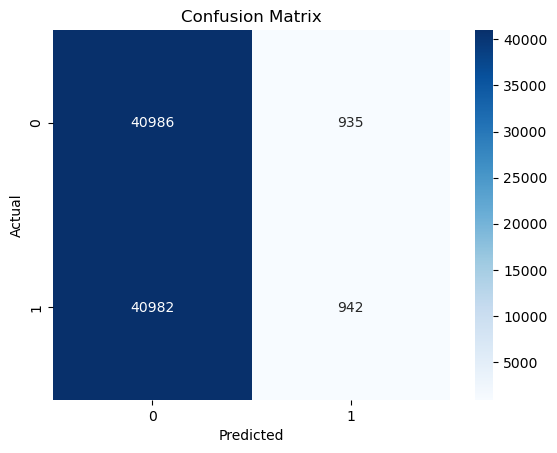

Accuracy: 0.50
              precision    recall  f1-score   support

      Normal       0.50      0.98      0.66     41921
       Fault       0.50      0.02      0.04     41924

    accuracy                           0.50     83845
   macro avg       0.50      0.50      0.35     83845
weighted avg       0.50      0.50      0.35     83845



In [31]:
rnn_model = tinyGru_RNN(X_train_seq, X_test_seq, y_train_seq, y_test_seq)


In [34]:
quant_tflite = postTrainGruQuantizeQndDeploy(rnn_model, X_train_seq, X_test_seq, y_train_seq, y_test_seq)

Converting with post-training int8 quantization...
INFO:tensorflow:Assets written to: /tmp/tmp8xi84h1k/assets


INFO:tensorflow:Assets written to: /tmp/tmp8xi84h1k/assets


Saved artifact at '/tmp/tmp8xi84h1k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 3), dtype=tf.float32, name='keras_tensor_38')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140600879954640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879952336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879955216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879954064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879954256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879952720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879947152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879955408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140600879954448: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/anas/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1767202735.230383   50114 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767202735.230397   50114 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-31 19:38:55.230539: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8xi84h1k
2025-12-31 19:38:55.231404: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-31 19:38:55.231411: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8xi84h1k
2025-12-31 19:38:55.247511: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-31 19:38:55.304258: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle 

ConverterError: <unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_4_1/gru_1/TensorArrayV2_1@__inference_function_8978700"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_8978751"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_4_1/gru_1/TensorArrayV2_1@__inference_function_8978700"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_8978751"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [ ]:
import tensorflow as tf

# Path to your model file
model_path = "/media/anas/Media/PRACTICING/Car-Monitoring-System/AI_Models/Predictive Maintenance/embedded models/Engine Bearing/engine_nn_quant_three_features.tflite"

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== Model Summary ===")
print(f"Model path: {model_path}\n")

print("Inputs:")
for i, detail in enumerate(input_details):
    print(f"  Input {i}:")
    print(f"    Name: {detail['name']}")
    print(f"    Shape: {detail['shape']}")
    print(f"    Data type: {detail['dtype']}")
    print(f"    Quantization: scale={detail['quantization_parameters']['scales']}, zero_point={detail['quantization_parameters']['zero_points']}")
    print()

print("Outputs:")
for i, detail in enumerate(output_details):
    print(f"  Output {i}:")
    print(f"    Name: {detail['name']}")
    print(f"    Shape: {detail['shape']}")
    print(f"    Data type: {detail['dtype']}")
    print(f"    Quantization: scale={detail['quantization_parameters']['scales']}, zero_point={detail['quantization_parameters']['zero_points']}")
    print()